In [12]:
#region imports
import pandas as pd
from sklearn.preprocessing import power_transform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
#endregion imports

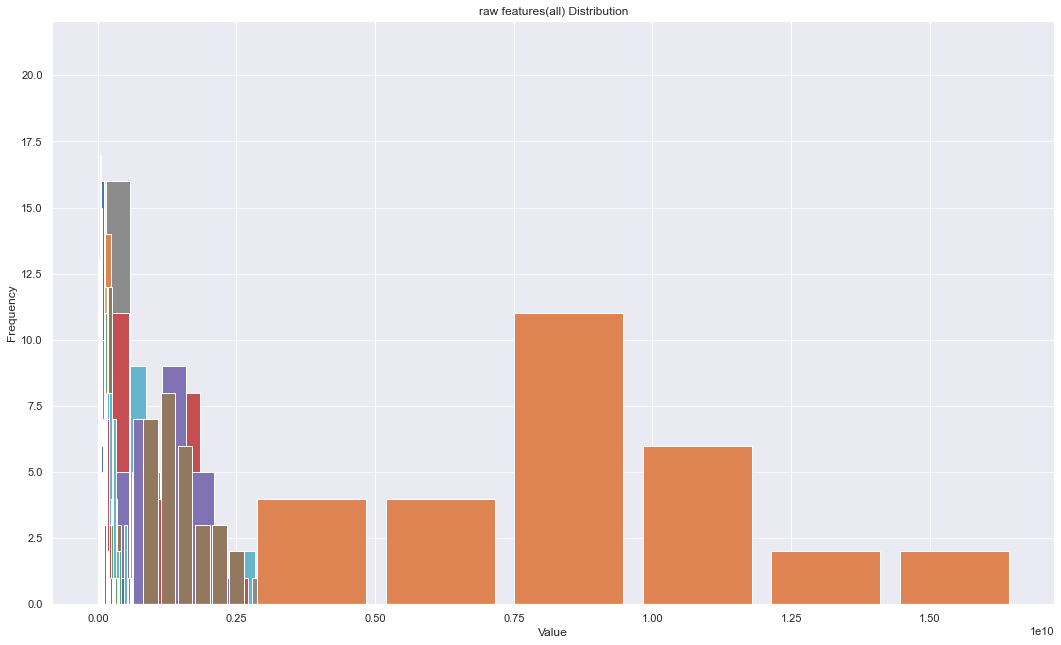

In [13]:
#region read and normalize data
data = pd.read_csv(r"C:\Users\vinic\Desktop\MD challenge\proteomics_data.csv")
data_feats = list(data.columns)
data_feats.pop(0) #get ID col out of features names

#verify if data is normalized
plt.figure(figsize=(16,10))
for feat in data_feats:
    plt.hist(x=data[feat], bins='auto',
                            rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('raw features(all) Distribution')
plt.show()

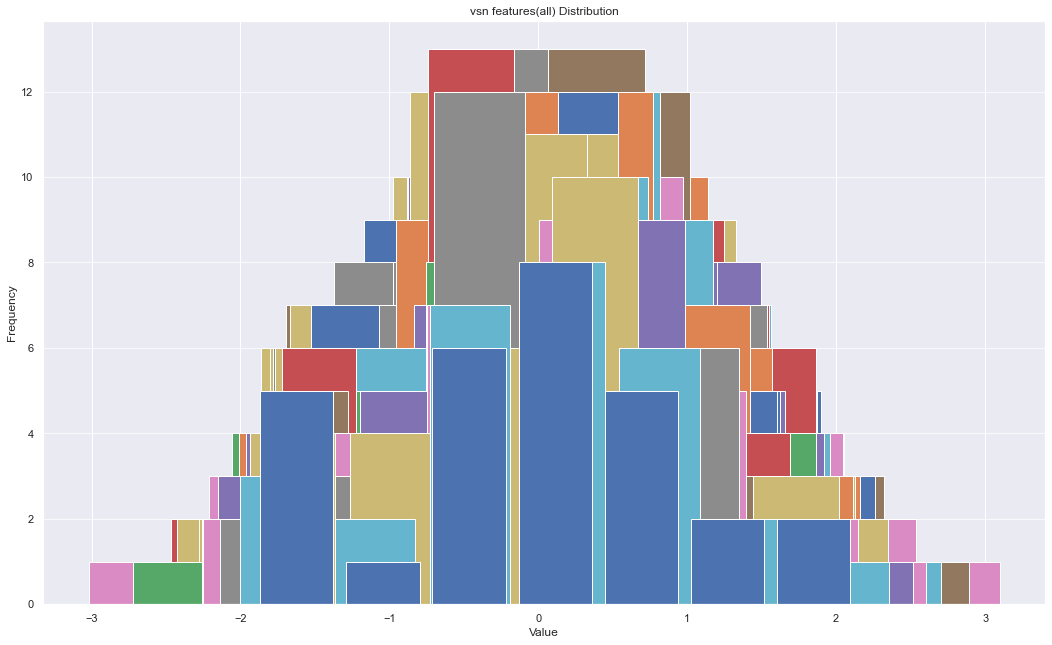

In [14]:
#variance stabilization normalization
data_normalized = power_transform(data[data_feats],method='box-cox')
data_normalized = pd.DataFrame(data_normalized)
data_normalized.columns = data_feats

#view normalized data
plt.figure(figsize=(16,10))
for feat in data_feats:
    plt.hist(x=data_normalized[feat], bins='auto',
                            rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('vsn features(all) Distribution')
plt.show()
#endregion read and normalize data

In [15]:
#region Analysis

#PCA
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(data_normalized[data_feats].values)

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1]
data['pca-three'] = pca_result[:,2] 


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13360465 0.08643901 0.06395656]


In [16]:
#t-sne
#using t-sne with pca results for more accurate results

tsne = TSNE(n_components=2, verbose=1, 
            perplexity=5, learning_rate=15, angle = 0.2,
            random_state=42)
tsne_pca_results = tsne.fit_transform(pca_result)

data['tsne-pca-one'] = tsne_pca_results[:,0]
data['tsne-pca-two'] = tsne_pca_results[:,1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 29 samples in 0.000s...
[t-SNE] Computed neighbors for 29 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 29 / 29
[t-SNE] Mean sigma: 3.261425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.059566
[t-SNE] KL divergence after 1000 iterations: 0.292859


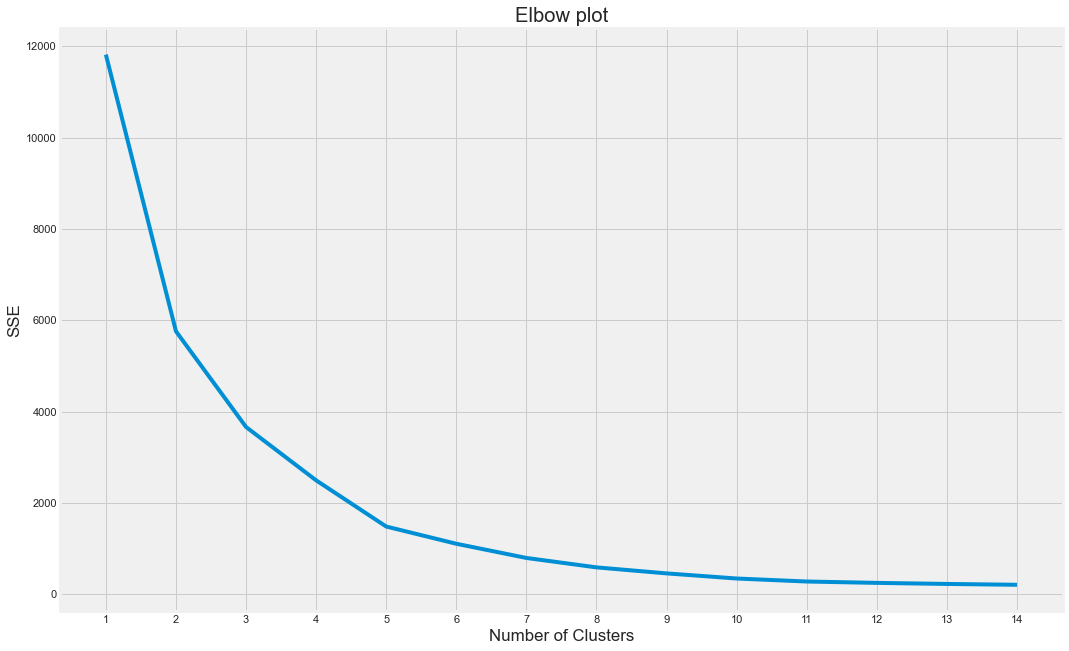

In [17]:
#kmeans
#using t-sne results for more accurate clustering
#guessing data will have no more than 15 clusters
sse=[]
for k in range(1,15):
    kmeans = KMeans(init="random",
                n_clusters=k,
                n_init=10,
                max_iter=300,
                random_state=42)
    kmeans.fit(data[['tsne-pca-one','tsne-pca-two']])
    sse.append(kmeans.inertia_)

#elbow plot
plt.figure(figsize=(16,10))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow plot")
plt.show()

In [18]:
kl = KneeLocator(range(1,15), sse, curve = "convex", direction="decreasing")
sse_elbow = kl.elbow

#run kmeans with determined cluster number
kmeans = KMeans(init="random",
                n_clusters=sse_elbow,
                n_init=10,
                max_iter=300,
                random_state=42)
kmeans.fit(data[['tsne-pca-one','tsne-pca-two']])

data['predicted_group'] = kmeans.labels_
#endregion Analysis

Text(0.5, 1.0, 't-SNE')

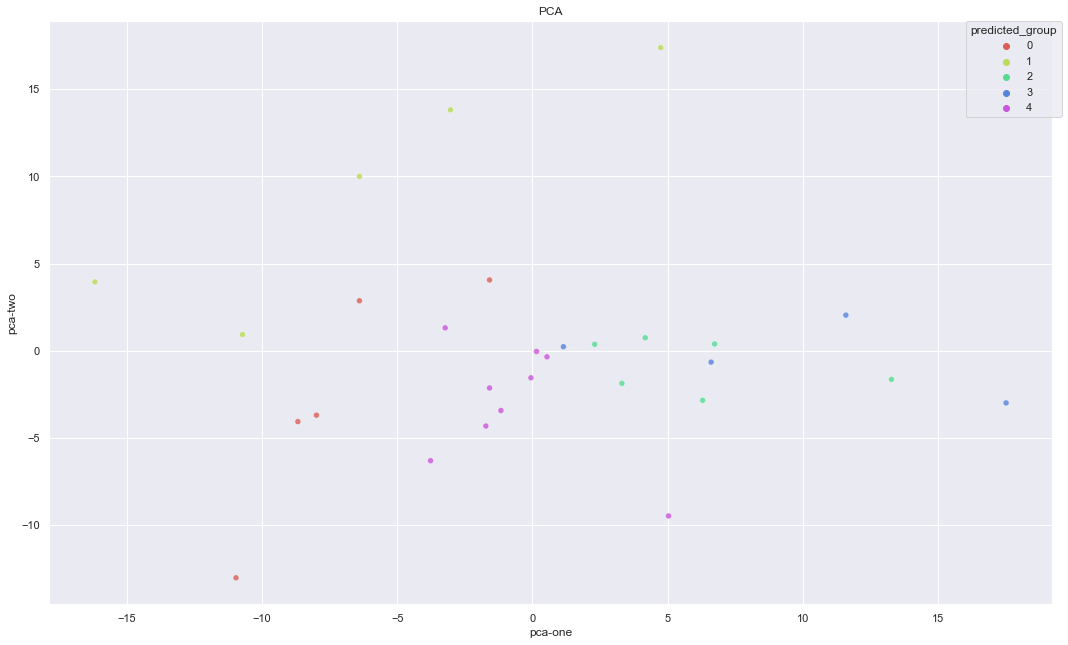

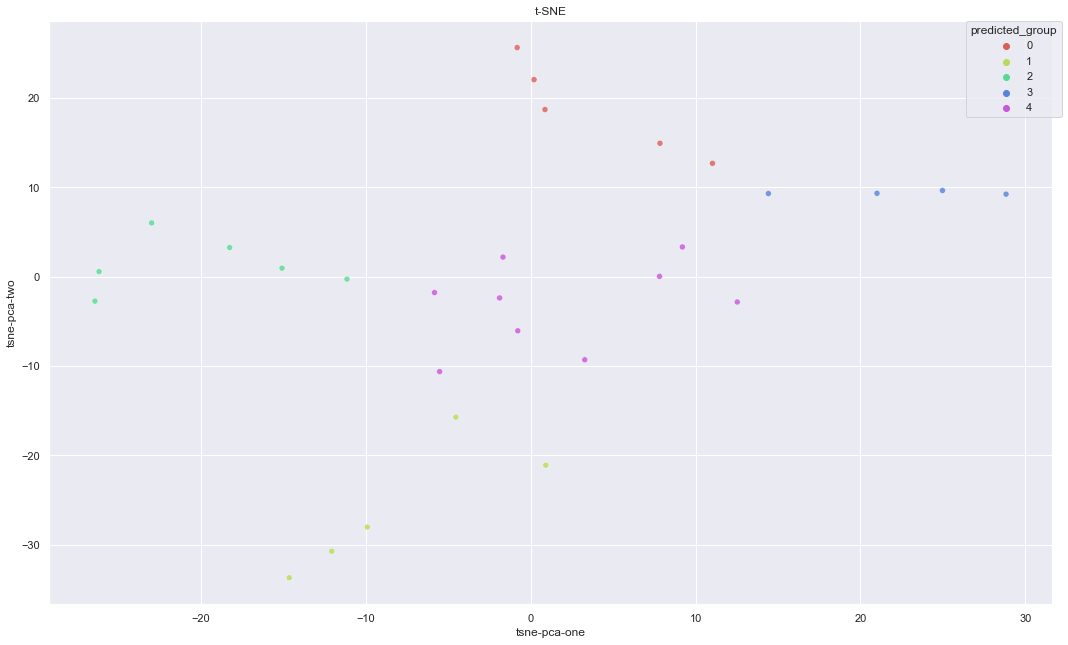

In [19]:
#region Visuals
sns.set(rc={'figure.facecolor':'white'})

#pca
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue = "predicted_group",
    palette=sns.color_palette("hls", sse_elbow),
    data=data,
    alpha=0.8
)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title = "predicted_group")
plt.title("PCA")

#tsne
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-pca-one", y="tsne-pca-two",
    hue = "predicted_group",
    markers=data_feats,
    palette=sns.color_palette("hls", sse_elbow),
    data=data,
    alpha=0.8,
)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, title = "predicted_group")
plt.title("t-SNE")
#endregion Visuals

In [20]:
display(data[['ID','predicted_group']])

,ID,predicted_group
0,Participant 1,0
1,Participant 2,3
2,Participant 3,4
3,Participant 4,1
4,Participant 5,1
5,Participant 6,4
6,Participant 7,4
7,Participant 8,3
8,Participant 9,1
9,Participant 10,4
